# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 9.0MB/s 


# Evn

In [6]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [7]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [8]:
!nvidia-smi

Wed Feb  3 06:34:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# data dir
data_dir = '/content/drive/MyDrive/Data/nlp'
os.listdir(data_dir)

['kowiki',
 'ko_32000.model',
 'ko_32000.vocab',
 '.ipynb_checkpoints',
 'nsmc',
 'quora',
 'songys']

In [11]:
# quora dir
quora_dir = os.path.join(data_dir, 'quora')
if not os.path.exists(quora_dir):
    os.makedirs(quora_dir)
os.listdir(quora_dir)

['kor_pair_train.csv', 'kor_Pair_test.csv', 'stub.hdf5', 'stub.csv']

# Vocabulary & config

In [42]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [43]:
n_vocab = len(vocab)  # number of vocabulary
n_seq_1 = 26  # number of sequence 1
n_seq_2 = 27  # number of sequence 2
d_model = 256  # dimension of model
n_out = 2  # number of output class

# 모델링

In [57]:
def build_model(n_vocab, d_model, n_seq_1, n_seq_2):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq_1: 문장 1 길이 (단어 수)
    :param n_seq_2: 문장 2 길이 (단어 수)
    """
    inputs_1 = tf.keras.layers.Input((n_seq_1,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((n_seq_2,))  # (bs, n_seq_2)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    ####################################
    # RNN or CNN 추가해 보세요.
    rnn_11 = tf.keras.layers.LSTM(units=128, return_sequences=True)
    rnn_12 = tf.keras.layers.LSTM(units=256, return_sequences=True)
    hidden_1 = rnn_11(hidden_1)
    hidden_1 = rnn_12(hidden_1)

    cnn_21 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='causal')
    cnn_22 = tf.keras.layers.Conv1D(filters=256, kernel_size=7, padding='same')
    hidden_2 = cnn_21(hidden_2)
    hidden_2 = cnn_22(hidden_2)
    ####################################
    # 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool_1 = pool(hidden_1)  # (bs, d_model)
    hidden_pool_2 = pool(hidden_2)  # (bs, d_model)
    # distance 계산 ||a - b||
    distance = K.sum(K.abs(hidden_pool_1 - hidden_pool_2), axis=-1)
    outputs = K.exp(-distance)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=outputs)
    return model

In [62]:
def build_model(n_vocab, d_model, n_seq_1, n_seq_2):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq_1: 문장 1 길이 (단어 수)
    :param n_seq_2: 문장 2 길이 (단어 수)
    """
    inputs_1 = tf.keras.layers.Input((n_seq_1,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((n_seq_2,))  # (bs, n_seq_2)
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    ####################################
    lstm = tf.keras.layers.LSTM(units=d_model, go_backwards=True)
    hidden_pool_1 = lstm(hidden_1)
    hidden_pool_2 = lstm(hidden_2)
    ####################################
    # distance 계산 ||a - b||
    distance = K.sum(K.abs(hidden_pool_1 - hidden_pool_2), axis=-1)
    outputs = K.exp(-distance)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=outputs)
    return model

# All Data Project

## Data


In [44]:
df_train = pd.read_csv(os.path.join(quora_dir, 'kor_pair_train.csv'), delimiter=',')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [45]:
df_train = df_train.dropna()
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [46]:
df_test = pd.read_csv(os.path.join(quora_dir, 'kor_Pair_test.csv'), delimiter=',')
df_test

,test_id,question1,question2,is_duplicate,Unnamed: 4
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,NaN
1,2,2년 가량의 연애,2년 만났어,0,NaN
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,NaN
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,NaN
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,NaN
...,...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1,NaN
685,686,휴대폰 액정 깨졌어,액정 깨짐,0,NaN
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1,NaN


In [47]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [48]:
df_test = df_test.dropna()
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [49]:
def load_data(df, n_seq_1, n_seq_2):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_seq_1: number of sequence 1
    :param n_seq_2: number of sequence 2
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    inputs_1 = np.zeros((len(df), n_seq_1)).astype(np.int32)
    inputs_2 = np.zeros((len(df), n_seq_2)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        is_duplicate = row['is_duplicate']
        question1 = row['question1']
        question2 = row['question2']
        # print(is_duplicate, question1, question2)

        tokens_1 = vocab.encode_as_pieces(question1)
        # print(len(tokens_1), ':', tokens_1)
        tokens_2 = vocab.encode_as_pieces(question2)
        # print(len(tokens_2), ':', tokens_2)

        token_ids_1 = vocab.encode_as_ids(question1)
        # print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 = vocab.encode_as_ids(question2)
        # print(len(token_ids_2), ':', token_ids_2)

        token_ids_1 = token_ids_1[:n_seq_1]
        # print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 = token_ids_2[:n_seq_2]
        # print(len(token_ids_2), ':', token_ids_2)

        token_ids_1 += [0] * (n_seq_1 - len(token_ids_1))
        # print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 += [0] * (n_seq_2 - len(token_ids_2))
        # print(len(token_ids_2), ':', token_ids_2)

        labels[index] = 1 - is_duplicate  # 0 -> 1, 1 -> 0
        inputs_1[index] = token_ids_1
        inputs_2[index] = token_ids_2
        index += 1
    return inputs_1, inputs_2, labels

In [50]:
# train data 생성
train_inputs_1, train_inputs_2, train_labels = load_data(df_train, n_seq_1, n_seq_2)
train_inputs_1, train_inputs_2, train_labels

(array([[ 3800,    26,  7314, ...,     0,     0,     0],
        [   67,    15,  8256, ...,     0,     0,     0],
        [   67,    15,    62, ...,     0,     0,     0],
        ...,
        [17834,    10,    20, ...,     0,     0,     0],
        [17834,  1151,  4468, ...,     0,     0,     0],
        [ 2067, 17548,    22, ...,     0,     0,     0]], dtype=int32),
 array([[   67,    15, 13442, ...,     0,     0,     0],
        [   67,    15,   218, ...,     0,     0,     0],
        [  242,    15,    85, ...,     0,     0,     0],
        ...,
        [ 5135, 29356,    29, ...,     0,     0,     0],
        [17834,  1151,  4468, ...,     0,     0,     0],
        [ 5135,    13, 20337, ...,     0,     0,     0]], dtype=int32),
 array([0., 0., 0., ..., 0., 1., 0.]))

In [51]:
# test data 생성
test_inputs_1, test_inputs_2, test_labels = load_data(df_test, n_seq_1, n_seq_2)
test_inputs_1, test_inputs_2, test_labels

(array([[  513,   704,     9, ...,     0,     0,     0],
        [   36,    15,  5657, ...,     0,     0,     0],
        [   36,    15,  7314, ...,     0,     0,     0],
        ...,
        [22848, 27427,  4221, ...,     0,     0,     0],
        [10736,  2101,  2329, ...,     0,     0,     0],
        [17194,    32,  3971, ...,     0,     0,     0]], dtype=int32),
 array([[ 5775,  2184,  1973, ...,     0,     0,     0],
        [   36,    15, 10711, ...,     0,     0,     0],
        [ 1680, 29038,    36, ...,     0,     0,     0],
        ...,
        [27427,  4221,  4418, ...,     0,     0,     0],
        [22827,   141, 17629, ...,     0,     0,     0],
        [ 1001,  3971,    18, ...,     0,     0,     0]], dtype=int32),
 array([0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 1., 0., 1., 1., 

## 학습

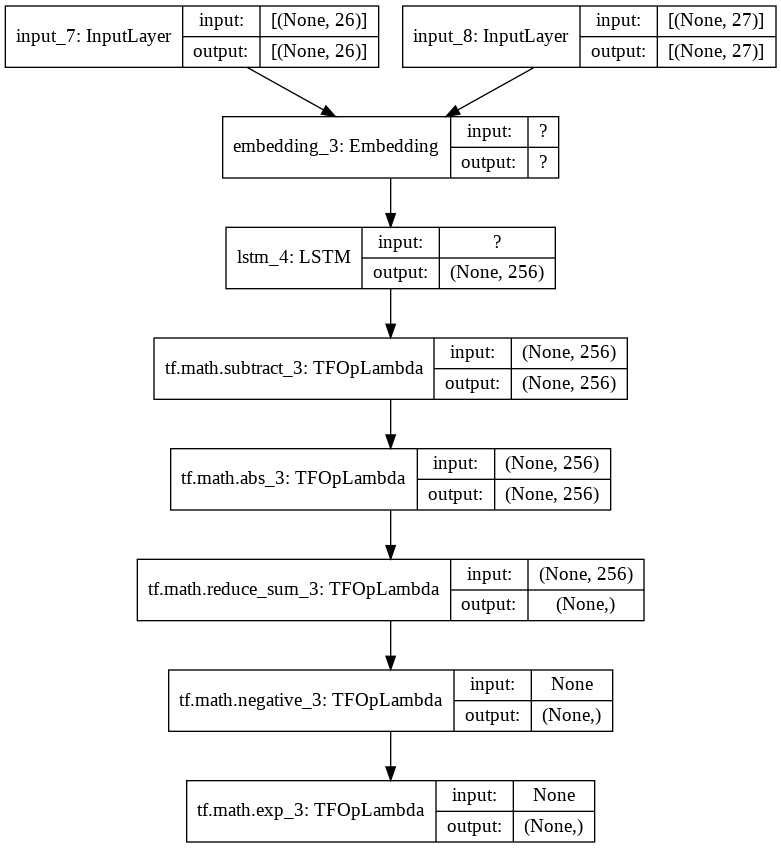

In [65]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [66]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

In [67]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(quora_dir, 'stub.hdf5'),
                                                  monitor='val_binary_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(quora_dir, 'stub.csv'))

In [68]:
# 모델 학습
history = model.fit((train_inputs_1, train_inputs_2),
                    train_labels,
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
27/27 [==============================] - 8s 162ms/step - loss: 0.2423 - binary_accuracy: 0.5707 - val_loss: 0.2114 - val_binary_accuracy: 0.6951

Epoch 00001: val_binary_accuracy improved from -inf to 0.69508, saving model to /content/drive/MyDrive/Data/nlp/quora/stub.hdf5
Epoch 2/100
27/27 [==============================] - 3s 121ms/step - loss: 0.1226 - binary_accuracy: 0.8808 - val_loss: 0.2019 - val_binary_accuracy: 0.7060

Epoch 00002: val_binary_accuracy improved from 0.69508 to 0.70597, saving model to /content/drive/MyDrive/Data/nlp/quora/stub.hdf5
Epoch 3/100
27/27 [==============================] - 3s 120ms/step - loss: 0.0817 - binary_accuracy: 0.9609 - val_loss: 0.1998 - val_binary_accuracy: 0.6867

Epoch 00003: val_binary_accuracy did not improve from 0.70597
Epoch 4/100
27/27 [==============================] - 3s 119ms/step - loss: 0.0636 - binary_accuracy: 0.9769 - val_loss: 0.1978 - val_binary_accuracy: 0.6867

Epoch 00004: val_binary_accuracy did not improv

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], 'g-', label='acc')
plt.plot(history.history['val_binary_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# train weight로 초기화
model.load_weights(os.path.join(quora_dir, 'stub.hdf5'))

In [ ]:
# 예측
logits = model.predict((test_inputs_1, test_inputs_2))
logits

In [ ]:
# 0.5를 기준으로 (0, 1) 결정
test_preds = (0.5 < logits).astype(np.int)
test_preds

In [ ]:
# confusion matrix 계산
confusion_matrix = np.zeros((2, 2)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

In [ ]:
# score 계산
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max(tp + tn + fp + fn, 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max(tp + fp, 1)
print(f'precision: {precision}')
recall = (tp) / max(tp + fn, 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max(precision + recall, 1)
print(f'f1: {f1}')

In [ ]:
def do_predict(model, n_seq_1, string1, n_seq_2, string2):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq_1: 입력 개수 1
    :param string1: 입력 문자열 1
    :param n_seq_1: 입력 개수 3
    :param string2: 입력 문자열 2
    """
    # token 생성: <string 1 tokens>, [PAD] tokens
    token1 = vocab.encode_as_ids(string1)[:n_seq_1]
    token1 += [0] * (n_seq_1 - len(token1))

    # token 생성: <string 2 tokens>, [PAD] tokens
    token2 = vocab.encode_as_ids(string2)[:n_seq_2]
    token2 += [0] * (n_seq_2 - len(token2))

    y_pred = model.predict((np.array([token1]), np.array([token2])))

    return "같음" if y_pred[0] > 0.5 else "다름"

In [ ]:
while True:
    print("string #1 > ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("string #2 > ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    print(f"output > {do_predict(model, n_seq_1, string1, n_seq_2, string2)}")

# KoBERT
- https://github.com/SKTBrain/KoBERT

## 설치

In [83]:
!pip install mxnet-cu101
!pip install gluonnlp
!pip install sentencepiece
!pip install transformers==2.2.2
!pip install urllib3==1.25.10
# 실행 후 런타임 재시작 실행 (urllib3를 다시 로드 해야 함)

     |███████████████████████████████▌| 834.1MB 1.5MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x6594e000 @  0x7facea99b615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.4MB 22kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 8.5MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp36-cp36m-linux_x86_64.whl size=588514 sha256=e422404f2c040bda1e4220a0ab4899f2dbe6b6b6e788c359e37190da73313bca
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 389kB 8.3MB

In [1]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-bg1zzr3y
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-bg1zzr3y
  Created wheel for kobert: filename=kobert-0.1.2-cp36-none-any.whl size=12734 sha256=59dab6f62e43cad0454c8b8514e89e3f05bf4fa2aa3bf284c9779d751fb76212
  Stored in directory: /tmp/pip-ephem-wheel-cache-t8g202l2/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


## Env

In [2]:
import os
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import json

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup

## KoBERT load

In [3]:
device = torch.device("cuda:0")

bert_model, bert_vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


## Data

In [12]:
df_train = pd.read_csv(os.path.join(quora_dir, 'kor_pair_train.csv'), delimiter=',')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [13]:
df_train = df_train.dropna()
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [14]:
df_test = pd.read_csv(os.path.join(quora_dir, 'kor_Pair_test.csv'), delimiter=',')
df_test

,test_id,question1,question2,is_duplicate,Unnamed: 4
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,NaN
1,2,2년 가량의 연애,2년 만났어,0,NaN
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,NaN
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,NaN
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,NaN
...,...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1,NaN
685,686,휴대폰 액정 깨졌어,액정 깨짐,0,NaN
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1,NaN


In [15]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [16]:
df_test = df_test.dropna()
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [17]:
tokenizer = get_tokenizer()
bert_tokenizer = nlp.data.BERTSPTokenizer(tokenizer, bert_vocab, lower=False)

using cached model


In [19]:
class QuoraDataset(Dataset):
    def __init__(self, dataset, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = []
        self.labels = []
        for i, row in dataset.iterrows():
            if type(row["question1"]) == str and type(row["question2"]) == str:
                self.sentences.append(transform([row["question1"], row["question2"]]))
                self.labels.append(np.int32(row["is_duplicate"]))

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [21]:
max_len = 75
data_train = QuoraDataset(df_train, bert_tokenizer, max_len, True, True)
data_test = QuoraDataset(df_test, bert_tokenizer, max_len, True, True)

In [22]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)

## Train

In [23]:
class QuoraClassifier(nn.Module):
    def __init__(self, bert_model, d_model=768, n_output=2, dr_rate=0.1):
        super().__init__()
        self.bert_model = bert_model
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(d_model , n_output)
        self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert_model(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        out = self.dropout(pooler)
        return self.classifier(out)

In [24]:
model = QuoraClassifier(bert_model, dr_rate=0.1).to(device)

In [25]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [26]:
optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5)
loss_fn = nn.CrossEntropyLoss()

In [27]:
num_epochs = 5
warmup_ratio = 0.1
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [28]:
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [29]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [32]:
max_grad_norm = 1

best_acc = 0.0
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    p_bar = tqdm(train_dataloader)
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(train_dataloader):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % 10 == 9:
            p_bar.update(10)
            p_bar.set_description(f'epoch {e+1} batch {batch_id+1} loss {loss.data.cpu().numpy():0.4f} acc {train_acc / (batch_id+1):0.4f}')
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    with torch.no_grad():
        model.eval()
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            test_acc += calc_accuracy(out, label)
    val_acc = test_acc
    if best_acc < val_acc:
        best_acc = val_acc
        save_path = os.path.join(quora_dir, "kobert_quora.pth")
        torch.save(model.state_dict(), save_path)
        print(f"save model {save_path}")
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

epoch 1 train acc 0.9581307870370371
save model /content/drive/MyDrive/Data/nlp/quora/kobert_quora.pth
epoch 1 test acc 0.7703598484848485


epoch 2 train acc 0.9718171296296296
save model /content/drive/MyDrive/Data/nlp/quora/kobert_quora.pth
epoch 2 test acc 0.7992424242424242


epoch 3 train acc 0.9855613425925925
epoch 3 test acc 0.7949810606060606


epoch 4 train acc 0.989988425925926
epoch 4 test acc 0.793560606060606


epoch 5 train acc 0.9917245370370371
epoch 5 test acc 0.793560606060606
